# [Exploration 04] Movie Review Sentimental Classification
- 네이버 영화리뷰 corpus dataset을 이용해 **한국어 텍스트**의 감정분석을 한다.  

## 1. load data
- pd.read_table 을 이용해 불러온 데이터를 확인한다. 

In [120]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [121]:
print(train_data.document[0])
print(train_data.label[0])

train_data.info()
train_data.describe()

아 더빙.. 진짜 짜증나네요 목소리
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,label
count,1.500000e+05,150000.000000
mean,6.743533e+06,0.498847
std,2.919051e+06,0.500000
min,3.300000e+01,0.000000
25%,4.766881e+06,0.000000
50%,7.526840e+06,0.000000
75%,9.249435e+06,1.000000
max,1.027815e+07,1.000000


In [122]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


## 2. make data_loader()
- 데이터셋을 가공할 함수를 만든다. 
- **data_loader()**
    - 중복 데이터 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords)제거
    - 사전 word_to_index 구성
    - 텍스트를 사전 인덱스 스트링으로 변환
    - train, test, word_to_index로 리턴

In [123]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 중복 데이터 확인 
# nunique() : 중복되지 않은 데이터의 갯수 
print(train_data['document'].nunique())  #146182

# 결측치 확인 
print(train_data.isnull().values.any()) # True 
print(test_data.isnull().values.any()) # True 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)   # inplace=True 는 원본에서 제거한다. 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # inplace=True 는 원본에서 제거한다. 
    
    # NaN 결측치 제거 
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    # 결측치 재확인 
    print(train_data.isnull().values.any()) # False 
    print(test_data.isnull().values.any())  # False
    
    # 한국어 토크나이저로 토큰화(Mecab 이용)
    X_train = []
    for st in train_data['document']:
        temp_x = tokenizer.morphs(st)
        temp_x = [word for word in temp_x if not word in stopwords]   # 불용어 제거 
        X_train.append(temp_x)
        
    X_test = []
    for st in test_data['document']:
        temp_x_test = tokenizer.morphs(st)
        temp_x_test = [word for word in temp_x_test if not word in stopwords]   # 불용어 제거 
        X_test.append(temp_x_test)
        
    
    # word_to_index 만들기  
    words = np.concatenate(X_train).tolist()      # train data를 list로 만든다.
    counter = Counter(words)                      # 각 단어의 갯수와 단어를 키, 밸루로 하는 딕셔너리 생성 
    counter = counter.most_common(10000-4) 
                                       # pad, bos, unk, unused 를 제외하고 가장 자주나오는 만개의 단어를 가져온다. (딕셔너리)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링 -> 인덱스 스트링 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

146182
True
True
id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64
False
False


In [124]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

146182 49157
146182 49157


In [125]:
# index_to_word 생성 (전체파일을 생성하기 때문에 시간이 조금 걸린다)
index_to_word = {index:word for word, index in word_to_index.items()}

In [126]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 데이터 분석, 가공 
- 데이터의 분포를 확인해 적절한 문장의 길이를 정한다.
- 패딩을 한다. 

In [127]:
print(len(train_data.label))
print(len(test_data.label))
print(train_data.label[0], X_train[0])

146183
49158
0 [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [128]:
print("X_train's length :", len(X_train))
print("X_test's length :", len(X_test))

X_train's length : 146182
X_test's length : 49157


In [129]:
# 전체 데이터 셋 통합 
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [130]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 설계
(1) Conv1D

In [136]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 32)          3616      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

## 5. data split
- train_test_split을 이용해서 train, valid를 이용한다. 

In [132]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.1, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(131563, 41) (131563,)
(14619, 41) (14619,)


In [96]:
# 슬라이싱을 이용해서 split하는 코드 

# # validation set 10000건 분리
# x_val = X_train[:10000]   
# y_val = y_train[:10000]

# # validation set을 제외한 나머지 15000건
# partial_x_train = X_train[10000:]  
# partial_y_train = y_train[10000:]

# print(partial_x_train.shape)
# print(partial_y_train.shape)

## 6. run model

In [137]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/20
257/257 - 9s - loss: 0.4678 - accuracy: 0.7640 - val_loss: 0.3520 - val_accuracy: 0.8456
Epoch 2/20
257/257 - 1s - loss: 0.3211 - accuracy: 0.8630 - val_loss: 0.3365 - val_accuracy: 0.8538
Epoch 3/20
257/257 - 1s - loss: 0.2861 - accuracy: 0.8809 - val_loss: 0.3375 - val_accuracy: 0.8564
Epoch 4/20
257/257 - 1s - loss: 0.2518 - accuracy: 0.8982 - val_loss: 0.3558 - val_accuracy: 0.8520
Epoch 5/20
257/257 - 1s - loss: 0.2148 - accuracy: 0.9168 - val_loss: 0.3698 - val_accuracy: 0.8494
Epoch 6/20
257/257 - 1s - loss: 0.1765 - accuracy: 0.9353 - val_loss: 0.4021 - val_accuracy: 0.8471
Epoch 7/20
257/257 - 1s - loss: 0.1439 - accuracy: 0.9500 - val_loss: 0.4371 - val_accuracy: 0.8431
Epoch 8/20
257/257 - 1s - loss: 0.1186 - accuracy: 0.9603 - val_loss: 0.4938 - val_accuracy: 0.8403
Epoch 9/20
257/257 - 1s - loss: 0.0985 - accuracy: 0.9683 - val_loss: 0.5355 - val_accuracy: 0.8410
Epoch 10/20
257/257 - 1s - loss: 0.0838 - accuracy: 0.9738 - val_loss: 0.5896 - val_accuracy: 0.8344

In [139]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.9194 - accuracy: 0.8192
[0.919425904750824, 0.8191712498664856]


## 7. visualize model training history

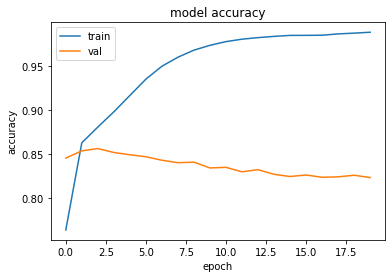

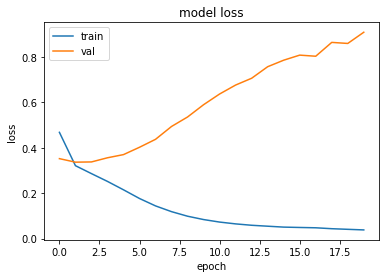

In [140]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 8. 학습된 embedding layer 분석
- model을 구성하는 첫번째 레이어는 embedding layer이다. 
- 이 레이어를 통해 학습이 잘 이루어졌는지 분석할 수 있다. 

In [141]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [147]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00735869,  0.03350969, -0.07834193, -0.12336007, -0.00590372,
       -0.04572642,  0.03360189,  0.00598928,  0.02057785,  0.02866328,
        0.0594396 , -0.00274949,  0.0107703 , -0.03913644,  0.04239653,
        0.02737738], dtype=float32)

In [156]:
word_vectors.similar_by_word("주인공")

[('ㅇㅇㅇ', 0.778947651386261),
 ('남매', 0.756324052810669),
 ('나와요', 0.742383599281311),
 ('껄', 0.7320163249969482),
 ('씽', 0.7317867279052734),
 ('미친다', 0.7196764945983887),
 ('센스', 0.7177374958992004),
 ('구속', 0.7176232933998108),
 ('박한별', 0.702104926109314),
 ('급박', 0.6988272666931152)]

- **'주인공'** 과 연관있는 단어를 word2vec 파일을 이용해서 뽑아낼 수있다.   
    : 하지만 관련이 없어 보이는 단어(벡터)가 출력되었다.   
    : 성능이 좋지 않다!

## 9. 한국어 word2vec embedding 활용 성능개선
- 한국어 word2vec 을 다운받아 사용한다.   
    [다운로드 경로](https://github.com/Kyubyong/wordvectors)

In [161]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = Word2Vec.load(word2vec_path)
ko_model.wv.most_similar("주인공")

[('여주인공', 0.7362918853759766),
 ('히로인', 0.7030971646308899),
 ('원작', 0.6740964651107788),
 ('악당', 0.6630157232284546),
 ('등장인물', 0.6590856909751892),
 ('악역', 0.6446496248245239),
 ('작중', 0.6274654865264893),
 ('극중', 0.6266963481903076),
 ('유령', 0.609932541847229),
 ('모험', 0.5971505641937256)]

### gensim 유사단어 찾기
- word2vec을 사용하지 않은 embedding layer보다 pretrained word2vec을 이용한 결과가 유사도가 높은 단어를 출력했다.  


- 해당 word2vec을 embedding layer에 적용해 기존 CNN 모델과의 성능비교를 해보고자 한다.

### embedding layer 교체

In [163]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [167]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_conv = keras.Sequential()
model_conv.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_conv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_conv.add(keras.layers.MaxPooling1D(5))
model_conv.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_conv.add(keras.layers.GlobalMaxPooling1D())
model_conv.add(keras.layers.Dense(32, activation='relu'))
model_conv.add(keras.layers.Dense(1, activation='sigmoid')) 

model_conv.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1, 32)             3616      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

word2vec을 적용하지 않은 모델보다 확연히 파라미터 수가 증가했다. (166,513 -> 2,027,121)

In [168]:
model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_conv.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 15s 56ms/step - loss: 0.5184 - accuracy: 0.7349 - val_loss: 0.5149 - val_accuracy: 0.7537
Epoch 2/20
266/266 [==============================] - 6s 23ms/step - loss: 0.3742 - accuracy: 0.8347 - val_loss: 0.4507 - val_accuracy: 0.7970
Epoch 3/20
266/266 [==============================] - 6s 23ms/step - loss: 0.3208 - accuracy: 0.8630 - val_loss: 0.4223 - val_accuracy: 0.8308
Epoch 4/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2902 - accuracy: 0.8791 - val_loss: 0.4041 - val_accuracy: 0.8315
Epoch 5/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2663 - accuracy: 0.8909 - val_loss: 0.3930 - val_accuracy: 0.8328
Epoch 6/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2445 - accuracy: 0.9011 - val_loss: 0.3804 - val_accuracy: 0.8333
Epoch 7/20
266/266 [==============================] - 6s 23ms/step - loss: 0.2262 - accuracy: 0.9105 - val_loss: 0.4195 - val_accuracy: 0.794

In [170]:
results = model_conv.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8110 - accuracy: 0.7638
[0.811042308807373, 0.7637772560119629]


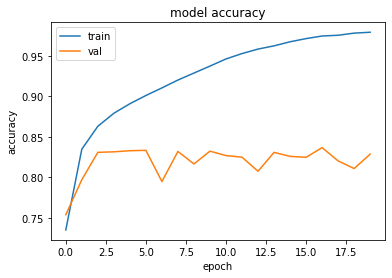

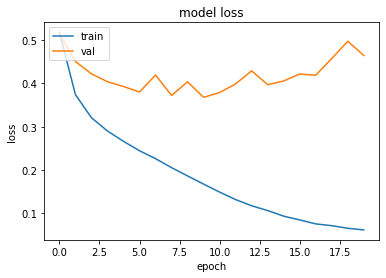

In [171]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 정리
---
1. 손글씨(digits), 와인(wine), 유방암(breast cancer) dataset을 sklearn모듈을 이용해 load한다.   
    - 데이터가 각 label당 고르게 분포하였는지 확인한다.
    - 데이터 description을 출력해 해당 데이터의 특성을 파악한다.
2. 학습과 평가를 위해 train, test 두 개의 dataset으로 나눈다.   
    - 이 때, 시드를 고정시기고, label의 분포를 고정시켜 학습 시 분포를 일정하게 유지하였다.  
3. 의사결정트리, 랜덤포레스트, SVM, SGD 분류, 로지스틱 회귀 **총 5개의 머신러닝 모델로 학습**한다.   
4. confusion matrix를 확인할 수 있는 classification report를 통해 정밀도, 재현율, f1 스코어를 확인한다.
5. 데이터 분포, 특성 등을 총합해 모델의 성능을 평가할 지표를 선택한다.

# 루브릭 평가
---
1. **다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**   
    - 3가지 이상의 모델이 성공적으로 시도됨.  
    
2. **gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**  
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
    
3. **한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**  
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

    
# 회고
---
## 새롭게 알게된(혹은 다시 정립한) 개념
- **random_state**와 **stratify**의 차이  

    (1) random_state  
    데이터셋을 train, test로 나눌 때 shuffle=False 파라미터를 설정하지 않으면 자동으로 무작위로 섞게 된다. 여기에서 무작위란 어떤 특정한 숫자로부터 시작한 난수처럼 보이는 수열을 말한다. 수열이 시작되는 특정한 숫자를 시드(seed)라고 하며, 이 시드를 수동으로 설정하고 다음에도 동일한 시드를 사용하면 동일하게 나눠진 데이터를 얻을 수 있다.
     따라서 데이터를 섞되 일정하게 섞고 싶을 때 사용하는 것이 seed이고, 이를 설정하는 파라미터가 random_state이다.  
     
    (2) stratify  
    label당 데이터의 분포를 일정하게 고정하는 파라미터이다. 예를 들어 label=[0, 1]이라면, 매 split을 진행할 때마다 70:30의 비율로 고정할 수 있다. ~~비율을 어떻게 정하는 지는 더 공부해봐야겠다.~~ 
    해당 파라미터는 classification report에서 학습이 제대로 되지 않아 특정 label의 모든 지표와 데이터 개수가 0으로 나오는 바람에 찾아보게 되었다. 
    

- **confusion matrix**와 **평가지표**  

    (1) 정밀도(precision)  
    정밀도는 예측한 모든 y_pred 중에 정확하게 예측한 값이 어느정도 있는가를 측정한 지표이다. 참과 거짓이 있다면 참이라고 예측한 값들 중 진짜 참은 얼마나 있는가?! 라고 말할 수 있다.  
    정밀도를 통해 **우리는 예측하고자 하는 label을 얼마나 정확하게 예측하는지**를 알 수 있다. 
    
    (2) 재현율(recall)  
    재현율은 참과 거짓이 있다면 모든 참 중 참이라고 예측한 값이 얼마나 있는가를 측정한 지표이다. 이를 통해 **우리가 예측한 결과가 얼마나 정확한지**를 알 수 있다. 
    
    (3) trouble shooting  
    true positive+false positive==0 이면, 정밀도를 정의할 수 없기에 0으로 출력되고, true positive+false negative==0 이면, 재현율을 정의할 수 없어 0으로 출력된다.


## 느낀 점
confusion matrix를 이해하고 정밀도, 재현율에 대한 차이를 이해하는 것이 어려웠다. 아직 완벽하게 체화하지 못했지만 앞으로 다른 데이터에도 적용하면서 체화할 수 있을 것이라고 생각한다. 머신러닝 모델을 모듈을 사용해서 세 줄로 학습, 예측, 평가까지 끝낼 수 있다는게 놀라웠고 코드가 짧은 만큼 다양한 파라미터가 있는 것 같다. nn을 사용할 때 loss가 0으로 수렴하는 과정을 보다가 1초도 안되는 시간안에 학습을 끝낸다는 것이 놀라우면서 학습과정을 보지 못해 답답하기도 했다. 또한 데이터의 특성에 따라 성과지표가 다를 수 있다는 것은 매우 중요한 포인트라고 생각한다. 학습 모델을 구축하기 전에 평가지표에 대한 정립을 하는 과정이 필요하다는 것을 배울 수 있었다. 